# Content and Objective

+ Show how an ARMA system is developping over time
+ Input signal might be chosen or white noise can be used

# Importing and Plotting Options

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from scipy import signal

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(20, 6) )

# Parameters

In [3]:
# switch for choosing different pol-zero constellations
switch = 2

In [4]:
if switch == 1:
    
    b_0_p = np.array( [ 1, 1, 1, 1 ] )
    a_1_q = np.array( [ ] )

elif switch == 2:
    
    b_0_p = np.array( [ 1 ] )
    a_1_q = np.array( [ .9, -.4, .2, -.7 ] )
    a_1_q /= np.linalg.norm( a_1_q, 1)
    #a_1_q = np.array( [ .9] )    
    
elif switch == 3:

    f_Nyquist = 1 / (2.0 )

    # apply "real-world" filtering
    cutoff_freq = f_Nyquist / 4

    ripple_db = 20                      # ripples and transition width of the filter
    width = f_Nyquist / 5.0

    N, beta = signal.kaiserord(ripple_db, width)    # find filter order and beta parameter

    # find filter and filter input
    taps = signal.firwin( N, cutoff=cutoff_freq,  window=('kaiser', beta), nyq = f_Nyquist )

    b_0_p = taps
    a_1_q = []
    
    
elif choice==4: # AR spectrum out of Kroschel
    b = [1] 
    a = [1 -1.372, 1.843, -1.238, .849] 
    sigma2 = .0032
    y = signal.lfilter( b, a, np.sqrt( sigma2 ) * Omega_1 * N_vec )  

elif choice==5: # broad spectrum out of Kroschel
    b = [1, 0, 0, 0, -.5]
    a = [1]
    sigma2 = .44
    Omega_1 = 1.0
    y = signal.lfilter( b, a, np.sqrt( sigma2 ) * Omega_1 * N_vec )

elif choice==6: # two sinusoids with noise
    Omega_0 = 1.0
    Omega_1 = 1.2
    y = np.sin( Omega_0 * N_vec ) + np.sin( Omega_1 * N_vec) + noise

elif choice==7: # two complex sinusoids with noise
    Omega_0 = 1.0
    Omega_1 = 1.2
    y = np.exp( 1j * Omega_0 * N_vec) + \
            np.exp( 1j * Omega_1 * N_vec)  + \
            noise

    
p = len( b_0_p ) - 1
q = len( a_1_q )

# Input Type

In [5]:
# length of output sequence
N_length = 10000


# white noise with given variance/power
sigma_x_2 = 1.0
x = np.sqrt( sigma_x_2 ) * np.random.randn( N_length )

# Time Series and Show Spectrum

In [6]:

y = np.array( [ b_0_p[ 0 ] * x[ 0 ] ] )

# loop for times
for n in range( 1, N_length ):

    # ma part
    ma = 0.0
    for _p in range( 0, np.min( ( n, p ) ) + 1  ):
        ma += b_0_p[ _p ] * x[ n - _p  ]
        
    # ar part
    ar = 0.0
    for _q in range( 1, np.min( ( n, q ) ) + 1 ):
        ar += a_1_q[ _q - 1 ] * y[ n - _q ]

    # apply
    y = np.append( y, ma - ar )

# Plotting

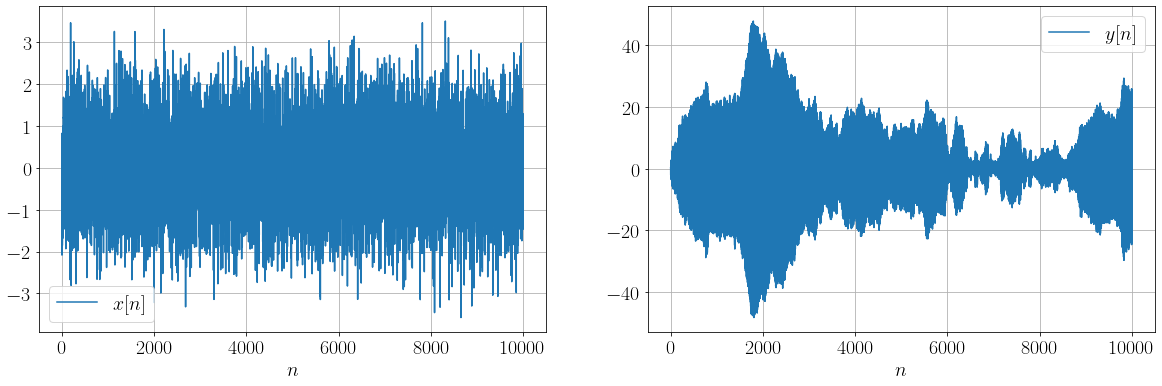

In [7]:
plt.figure()

plt.subplot(121)
plt.plot( x, label= '$x[n]$' )

plt.grid( True )
plt.xlabel('$n$')
plt.legend()

plt.subplot(122)
plt.plot( y, label= '$y[n]$' )

plt.grid( True )
plt.xlabel('$n$')
plt.legend()


# Find YW Parameters

In [8]:
########################
# acf estimator
########################
def est_acf(y, est_type):
    """
    estimates acf given a number of observation
    
    Remark: signal is assumed to be starting from 0 to length(y)-1
    
    IN: observations y, est_type (biased / unbiased)
    OUT: estimated acf, centered around 0
    """
    
    N = np.size( y )
    r = np.zeros_like( y )
    
    # loop lags of acf
    for k in np.arange(0, N):
        
        temp = np.sum( y[k:N] * (y[0:(N-k)]) )

        # type of estimator
        if est_type == 'biased':
            r[k] = temp/N
        elif est_type == 'unbiased':
            r[k] = temp/(N-k)
        
    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])     
   
    return  np.append(r_reverse[0:len(r)-1], r) 

In [9]:
##########################
# YW parameters
##########################

def find_parameters_yulewalker(y, order, s2 ):
    """
    estimates a_v parameters of filter using the Yule-Walker method
                
    IN: samples y, YW oder q
    OUT: parameters a_v
    """

    r = est_acf(y, 'biased') 
    #r = r/np.max(acf)
    N = int( (len(r)+1)/2 )

    # get matrix R for Yule-Walker     
    # note that R is not the autocorrelation matrix, but R = (ACF matrix)^*
    R = np.zeros([order+1, order+1], dtype=float)        
    for p in range(0, order+1):
        R[:,p] = r[N-1-p : N-1-p+order+1 ]
        
    # find and solve linear equation system for the coefficients
    b = np.matrix(np.append(s2, np.zeros(order))).T
    theta = np.linalg.solve(R, b)
    
    theta = np.array(theta / theta[0])

    return theta.T

In [10]:
print( find_parameters_yulewalker( y, q, 1. )[0][1:])
print( a_1_q )

[ 0.45533465 -0.18770408  0.06933248 -0.28685061]
[ 0.40909091 -0.18181818  0.09090909 -0.31818182]
